# Model Interpretability with Feature Visualization

A successful model interpretability should generate realistic and diverse samples that accurately describe each of the classes in the private dataset.


[Lucent](https://github.com/Animadversio/lucent)



# Set up Notebook

In [1]:
# CUDA 11.8
!pip install torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 530.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89989 sha256=cfa76c40cb7fc89f7d2bd6c92395a28ba1404e48658510da0e38edc41067faf9
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b1b44fe0dea1bb35234b09f2c22fb8ebb308679c922
Successfully built lit
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2

In [2]:
!pip install git+https://github.com/Animadversio/lucent.git

  Cloning https://github.com/Animadversio/lucent.git to /tmp/pip-req-build-axdd038u
  Running command git clone --filter=blob:none --quiet https://github.com/Animadversio/lucent.git /tmp/pip-req-build-axdd038u
  Resolved https://github.com/Animadversio/lucent.git to commit f393a48ef606dd25a5eba4f5b7af93e1249cd648
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.4 MB/s eta 0:00:00
  Created wheel for torch-lucent: filename=torch_lucent-0.1.8-py3-none-any.whl size=46339 sha256=7426c65cd4f7e1079a0fa831c17598df9818f6d8db9342316c729e4bcc65c084
  Stored in directory: /tmp/pip-ephem-wheel-cache-wcauvyh5/wheels/78/0e/6b/c12d17de061712cf3d136014cb5e74678b62f26

In [3]:
from lucent.optvis.transform import pad, jitter, random_rotate, random_scale
from lucent.optvis import render, transform, objectives, param
from lucent.optvis.param import gan

import torch
from torchvision import models
from torchvision import transforms

from imageio import imsave
from os.path import join
import numpy as np
import matplotlib.pylab as plt
import zipfile
import PIL.Image
from IPython.display import display

# Pretrained Mobilenet V2 Model
https://pytorch.org/hub/pytorch_vision_mobilenet_v2/


In [4]:
from lucent.modelzoo import mobilenet_v2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mobilenet_v2_model = mobilenet_v2(pretrained=True).to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 50.2MB/s]


# Visual Interpretations of DNNs

**Representation Inversion**: Starting from an image representation, find an image that minimizes some distance in the representation space. When given an encoding of a training image, to what extent can the image be reconstructed by searching for images that map to the same ML model encoding.

**Activation Maximization**: Seeks an image that maximally excites a certain component of the representation. The resulting image is representative of the visual stimuli that are selected by that component and helps understand its “meaning” or function. This type of visualization is sometimes referred to as “deep dream” as it can be interpreted as the result of the representation “imagining” a concept.

**Caricaturizing**: Modification of an initial image to exaggerate any pattern that excites the representation. This is different from activation maximization, as this emphasizes the meaning of combinations of representation components that are active together.

**Multifaceted Feature Visualization**: In each training class, images with diverse shapes and colors represent the same class concept and this technique seeks to re-create these different types of class images. For example, images of a horse facing left, facing right, and portraits (head pictures) all contain valid shapes within the “horse” class. Images of red, green and yellow bell peppers all represent valid colors within the ‘bell pepper’ class.

  https://arxiv.org/abs/1412.0035v1: “Understanding Deep Image Representations by Inverting Them",  Aravindh Mahendran and Andrea Vedaldi
  https://arxiv.org/abs/1602.03616: “ Multifaceted Feature Visualization”, Anh Nguyen, Jason Yosinski and Jeff Clune



Usage of more complex image priors / parametrizations like GANs to help feature visualization.

Use GAN as prior to do feature visualization.
This method is inspired by the work
    Nguyen, A., Dosovitskiy, A., Yosinski, J., Brox, T., & Clune, J.
    Synthesizing the preferred inputs for neurons in neural networks via deep generator networks.(2016) NIPS

The GAN model is imported from
    A. Dosovitskiy, T. Brox `Generating Images with Perceptual Similarity Metrics based on Deep Networks` (2016), NIPS.
    https://lmb.informatik.uni-freiburg.de/people/dosovits/code.html
the author translated the models (pool5-fc8) into pytorch and hosts the weights online.

In [5]:
from lucent.optvis.param.gan import upconvGAN
G = upconvGAN("fc8")
# G = upconvGAN("fc7")
#G = upconvGAN("fc6")
G.requires_grad_(False)
G.cuda()
def GANparam(batch=1, sd=1):
    code = (torch.randn((batch, G.codelen)) * sd).to("cuda").requires_grad_(True)
    imagef = lambda:  G.visualize(code)
    return [code], imagef

downloading weights of `upconvGAN_fc8.pt` to /root/.cache/torch/hub/checkpoints/upconvGAN_fc8.pt


100%|██████████| 174M/174M [00:11<00:00, 14.6MiB/s]


First we need to provide a way for the images created in the GAN inversions can be saved.

In [6]:
import PIL
from PIL import Image

def export(image, image_name=None):
  image_name = image_name or "image.jpg"
  assert len(image.shape) in [
      3,
      4,
  ], "Image should have 3 or 4 dimensions, invalid image shape {}".format(image.shape)
  # Change dtype for PIL.Image
  image = (image * 255).astype(np.uint8)
  if len(image.shape) == 4:
      image = np.concatenate(image, axis=1)
  Image.fromarray(image).save(image_name)


We perform machine learning model inversion using gradient ascent with regularization against each output class of a model. Rather than maximizing the ‘softmax’ output layer of probabilities, we maximize over the penultimate ‘labels’ layer, as this produces visually superior results.

This cell creates the parameters and transformers for the GAN model inversion. It also defines the ImageNet classes that will be inverted with the mobilenet_v2 model. Choose classes [here](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

100%|██████████| 512/512 [00:14<00:00, 34.17it/s]



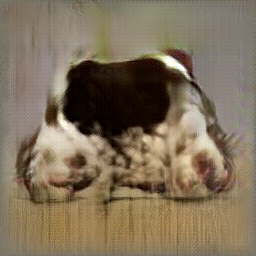

100%|██████████| 512/512 [00:14<00:00, 34.64it/s]



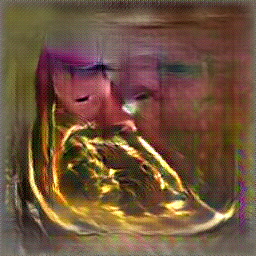

100%|██████████| 512/512 [00:15<00:00, 33.52it/s]



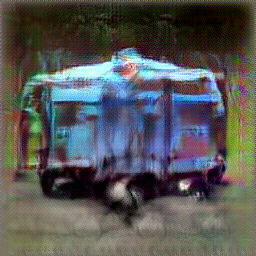

100%|██████████| 512/512 [00:14<00:00, 34.24it/s]



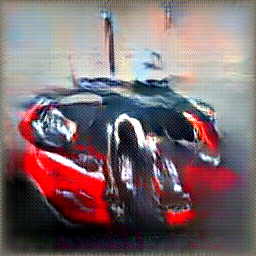

In [7]:
tfms = [pad(12, mode="constant", constant_value=.5),
        jitter(8),
        random_scale([1 + (i - 5) / 50. for i in range(11)]),
        random_rotate(list(range(-10, 11)) + 5 * [0]),
        jitter(4),]

GANparam_f = lambda: GANparam(batch=1, sd=1)
GANopt = lambda params: torch.optim.Adam(params, 5e-2)

run = 1
class_labels = [217,566,569,817]       # English springer, French horn, garbage truck, sports car

# rounds of inversion
for i in range(len(class_labels)):
  obj = objectives.channel('labels', n_channel=class_labels[i], batch=None)

  inv_img_d = render.render_vis(mobilenet_v2_model, obj, GANparam_f, GANopt, transforms=tfms, thresholds=(512,), show_inline=True, show_image=True, save_image=True, image_name='mobilenet_{}_{}.jpg'.format(class_labels[i], run))
  for j in range(len(inv_img_d[0])):
    export(inv_img_d[0][j], 'mobilenet_{}_{}_inv_{}.jpg'.format(class_labels[i], run, j))

# Diversity
The diversity objective is used to generate multiple different visualizations from a single neuron or channel.
With the diversity objective, we have to submit a batch of images for optimization. The diversity objective then tries to maximize the difference in feature representations between the images in the batch.  Diversity can help in revealing the different "facets" of a class.

https://distill.pub/2017/feature-visualization/

100%|██████████| 512/512 [00:23<00:00, 22.25it/s]



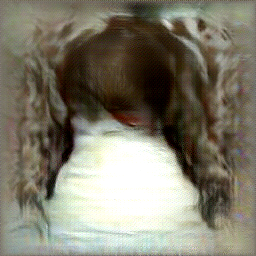
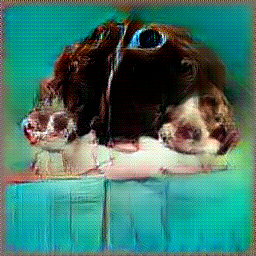
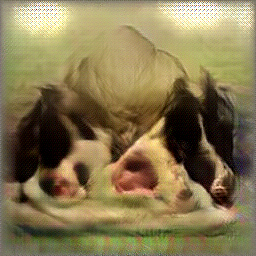
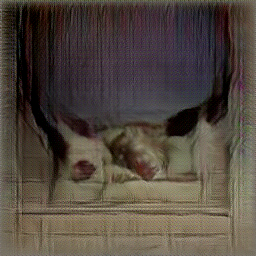

100%|██████████| 512/512 [00:23<00:00, 22.03it/s]



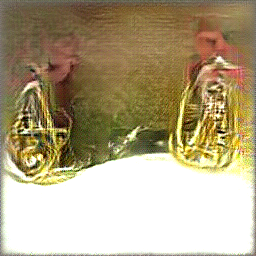
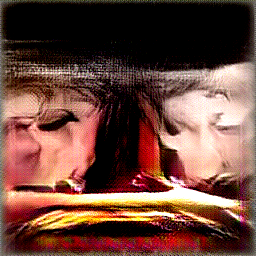
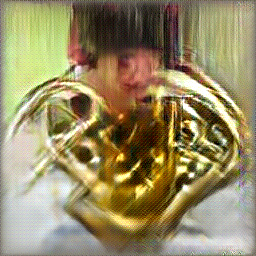
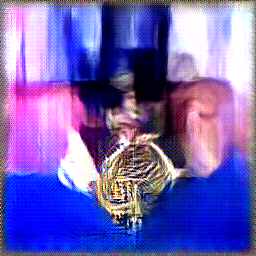

100%|██████████| 512/512 [00:22<00:00, 22.34it/s]



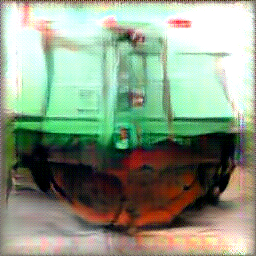
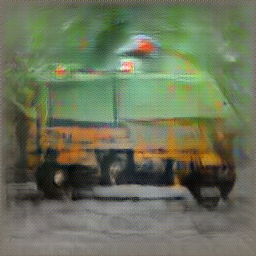
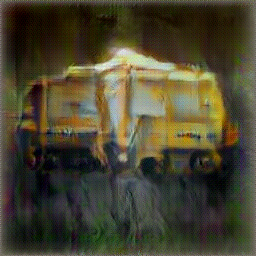
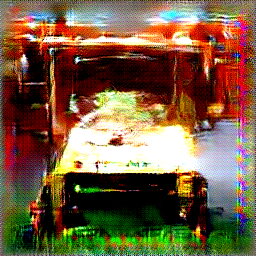

100%|██████████| 512/512 [00:24<00:00, 21.18it/s]



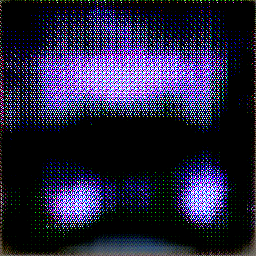
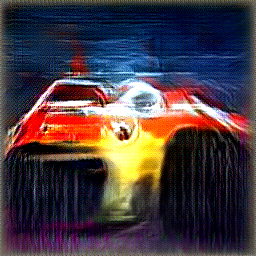
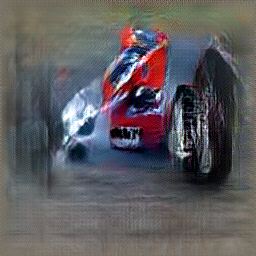
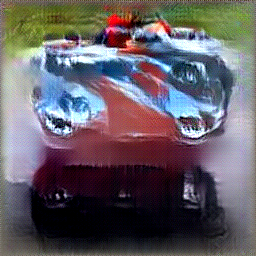

In [8]:
tfms = [pad(12, mode="constant", constant_value=.5),
        jitter(8),
        random_scale([1 + (i - 5) / 50. for i in range(11)]),
        random_rotate(list(range(-10, 11)) + 5 * [0]),
        jitter(4),]

GANparam_f = lambda: GANparam(batch=4, sd=1)
GANopt = lambda params: torch.optim.Adam(params, 5e-2)

run = 2
class_labels = [217,566,569,817]       # English springer, French horn, garbage truck, sports car

# rounds of inversion
for i in range(len(class_labels)):
  obj = objectives.channel('labels', n_channel=class_labels[i], batch=None) - .25e1 * objectives.diversity('features_15')

  inv_img_d = render.render_vis(mobilenet_v2_model, obj, GANparam_f, GANopt, transforms=tfms, thresholds=(512,), show_inline=True, show_image=True, save_image=True, image_name='mobilenet_{}_{}.jpg'.format(class_labels[i], run))
  for j in range(len(inv_img_d[0])):
    export(inv_img_d[0][j], 'mobilenet_{}_{}_inv_{}.jpg'.format(class_labels[i], run, j))

## Class Predictions

In [9]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# @title
def prCyan(skk): print("\033[96m {}\033[00m" .format(skk))

Now we take the images that were saved to the files in this Notebook and print the modelnet_v2 class predictions from the inverted images.

In [10]:
import glob
mn_files = glob.glob("*inv_*.jpg")
inv_to_predict = []
class_ids = []

for file in mn_files:
  prCyan(file)
  # get class label from file name
  class_ids.append(file[10:13])

  image = Image.open(file)
  inv_to_predict.append(image)
  transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])

  image = transform(image)
  print()

  print("Mobilenet_v2")
  output = mobilenet_v2_model(image.to(device).unsqueeze(0))
  _, predicted = torch.max(output, 1)
  print(predicted.item())
  top_5_probs, top_5_indices = torch.topk(output, 5)
  print(top_5_indices)
  print(top_5_probs)
  print()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


 mobilenet_217_2_inv_0.jpg

Mobilenet_v2
216
tensor([[216, 153, 212, 219, 215]], device='cuda:0')
tensor([[15.6070, 15.0341, 14.1562, 13.7597, 13.4441]], device='cuda:0',
       grad_fn=<TopkBackward0>)

 mobilenet_566_1_inv_0.jpg

Mobilenet_v2
566
tensor([[566, 513, 875, 776, 558]], device='cuda:0')
tensor([[22.4876, 19.3201, 18.0734, 16.8876, 11.2585]], device='cuda:0',
       grad_fn=<TopkBackward0>)

 mobilenet_566_2_inv_0.jpg

Mobilenet_v2
566
tensor([[566, 513, 875, 776, 676]], device='cuda:0')
tensor([[18.6452, 15.3214, 14.0005, 13.1167, 11.7647]], device='cuda:0',
       grad_fn=<TopkBackward0>)

 mobilenet_217_2_inv_3.jpg

Mobilenet_v2
215
tensor([[215, 172, 217, 242, 162]], device='cuda:0')
tensor([[11.3895, 10.3228, 10.2597,  9.9969,  9.9512]], device='cuda:0',
       grad_fn=<TopkBackward0>)

 mobilenet_817_2_inv_0.jpg

Mobilenet_v2
904
tensor([[904, 632, 651, 700, 599]], device='cuda:0')
tensor([[10.0411,  7.9663,  7.8382,  7.7939,  7.7188]], device='cuda:0',
       grad_f